<a href="https://colab.research.google.com/github/marcelounb/tensorflow_udacity/blob/master/07_Flowers_CNN_with_transfer_learning_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from keras.models import Sequential 
from keras.layers import Dense 
from keras.layers import Dropout 
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.optimizers import SGD

# Imports for the CNN
from keras.layers import Flatten 
from keras.layers.convolutional import Convolution2D 
from keras.layers.convolutional import MaxPooling2D
from keras import backend as K 
from random import randrange

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

import os

# Download the Flowers Dataset using TensorFlow Datasets
In the cell below you will download the Flowers dataset using TensorFlow Datasets. If you look at the TensorFlow Datasets documentation you will see that the name of the Flowers dataset is tf_flowers. 

You can also see that this dataset is only split into a TRAINING set. You will therefore have to use tfds.splits to split this training set into to a training_set and a validation_set. Do a [70, 30] split such that 70 corresponds to the training_set and 30 to the validation_set. 

Then load the tf_flowers dataset using tfds.load. Make sure the tfds.load function uses the all the parameters you need, and also make sure it returns the dataset info, so we can retrieve information about the datasets.

In [3]:
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:70%]', 'train[70%:]'],
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.


In [4]:
dataset_info

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.0,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

# Print Information about the Flowers Dataset
Now that you have downloaded the dataset, use the dataset info to print the number of classes in the dataset, and also write some code that counts how many images we have in the training and validation sets.

In [5]:
num_training_examples, num_validation_examples = 0,0

for item in training_set:
  num_training_examples +=1

for item in validation_set:
  num_validation_examples +=1

num_classes = dataset_info.features['label'].num_classes

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



The images in the Flowers dataset are not all the same size.

In [6]:
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]) )

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


# Reformat Images and Create Batches
In the cell below create a function that reformats all images to the resolution expected by MobileNet v2 (224, 224) and normalizes them. The function should take in an image and a label as arguments and should return the new image and corresponding label. Then create training and validation batches of size 32.

In [7]:
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255
  return image, label

BATCH_SIZE = 32
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

# Do Simple Transfer Learning with TensorFlow Hub
Let's now use TensorFlow Hub to do Transfer Learning. Remember, in transfer learning we reuse parts of an already trained model and change the final layer, or several layers, of the model, and then retrain those layers on our own dataset.

# Create a Feature Extractor
In the cell below create a feature_extractor using MobileNet v2. Remember that the partial model from TensorFlow Hub (without the final classification layer) is called a feature vector. Go to the TensorFlow Hub documentation to see a list of available feature vectors. Click on the tf2-preview/mobilenet_v2/feature_vector. Read the documentation and get the corresponding URL to get the MobileNet v2 feature vector. Finally, create a feature_extractor by using hub.KerasLayer with the correct input_shape parameter.

In [8]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

# Freeze the Pre-Trained Model
In the cell below freeze the variables in the feature extractor layer, so that the training only modifies the final classifier layer.

In [9]:
# Freezing the extractor layer
feature_extractor.trainable = False

# Attach a classification head
In the cell below create a tf.keras.Sequential model, and add the pre-trained model and the new classification layer. Remember that the classification layer must have the same number of classes as our Flowers dataset. Finally print a summary of the Sequential model.

In [10]:
def my_model():
  model = Sequential()
  model.add(feature_extractor)
  model.add(Dense(5))

  # compiling the model
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , optimizer= 'adam' , metrics=[ 'accuracy' ])
  return model

In [11]:
model = my_model()

# Train the model
In the cell bellow train this model like any other, by first calling compile and then followed by fit. Make sure you use the proper parameters when applying both methods. Train the model for only 6 epochs.

In [12]:
EPOCHS = 30

history = model.fit(train_batches, epochs=EPOCHS, validation_data=validation_batches)

Epoch 1/30
81/81 [==============================] - 7s 87ms/step - loss: 0.7993 - accuracy: 0.7123 - val_loss: 0.4648 - val_accuracy: 0.8538
Epoch 2/30
81/81 [==============================] - 6s 79ms/step - loss: 0.3869 - accuracy: 0.8708 - val_loss: 0.3621 - val_accuracy: 0.8847
Epoch 3/30
81/81 [==============================] - 6s 79ms/step - loss: 0.3096 - accuracy: 0.8992 - val_loss: 0.3279 - val_accuracy: 0.8892
Epoch 4/30
81/81 [==============================] - 6s 78ms/step - loss: 0.2589 - accuracy: 0.9214 - val_loss: 0.3072 - val_accuracy: 0.9010
Epoch 5/30
81/81 [==============================] - 6s 79ms/step - loss: 0.2257 - accuracy: 0.9334 - val_loss: 0.3033 - val_accuracy: 0.8955
Epoch 6/30
81/81 [==============================] - 6s 79ms/step - loss: 0.2000 - accuracy: 0.9432 - val_loss: 0.2903 - val_accuracy: 0.9019
Epoch 7/30
81/81 [==============================] - 6s 80ms/step - loss: 0.1741 - accuracy: 0.9545 - val_loss: 0.2843 - val_accuracy: 0.9055
Epoch 8/30
81

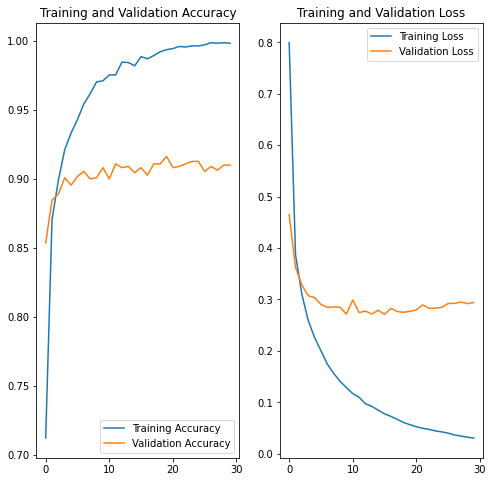

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Check Predictions
In the cell below get the label names from the dataset info and convert them into a NumPy array. Print the array to make sure you have the correct label names.

In [16]:
class_names = np.array(dataset_info.features['label'].names)

print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


# Create an Image Batch and Make Predictions
In the cell below, use the next() function to create an image_batch and its corresponding label_batch. Convert both the image_batch and label_batch to numpy arrays using the .numpy() method. Then use the .predict() method to run the image batch through your model and make predictions. Then use the np.argmax() function to get the indices of the best prediction for each image. Finally convert the indices of the best predictions to class names.

In [17]:
image_batch, label_batch = next(iter(train_batches))


image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

['dandelion' 'tulips' 'dandelion' 'tulips' 'sunflowers' 'roses'
 'sunflowers' 'dandelion' 'sunflowers' 'roses' 'tulips' 'dandelion'
 'dandelion' 'daisy' 'tulips' 'daisy' 'tulips' 'sunflowers' 'dandelion'
 'daisy' 'sunflowers' 'dandelion' 'daisy' 'dandelion' 'tulips' 'dandelion'
 'tulips' 'roses' 'sunflowers' 'tulips' 'dandelion' 'sunflowers']


Print True Labels and Predicted Indices
In the cell below, print the true labels and the indices of predicted labels.

In [18]:
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [0 2 0 2 3 4 3 0 3 4 2 0 0 1 2 1 2 3 0 1 3 0 1 0 2 0 2 4 3 2 0 3]
Predicted labels:  [0 2 0 2 3 4 3 0 3 4 2 0 0 1 2 1 2 3 0 1 3 0 1 0 2 0 2 4 3 2 0 3]


Plot Model Predictions

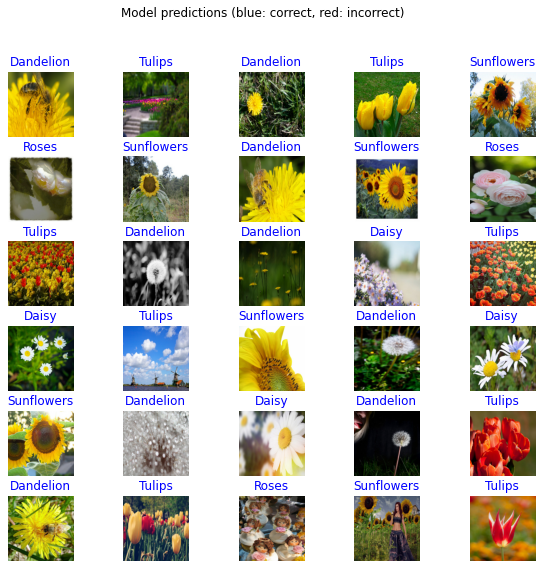

In [19]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

# Perform Transfer Learning with the Inception Model
Go to the TensorFlow Hub documentation and click on tf2-preview/inception_v3/feature_vector. This feature vector corresponds to the Inception v3 model. In the cells below, use transfer learning to create a CNN that uses Inception v3 as the pretrained model to classify the images from the Flowers dataset. Note that Inception, takes as input, images that are 299 x 299 pixels. Compare the accuracy you get with Inception v3 to the accuracy you got with MobileNet v2.

In [20]:
IMAGE_RES = 299

(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:70%]', 'train[70%:]'],
)
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
  input_shape=(IMAGE_RES, IMAGE_RES, 3),
  trainable=False)

model_inception = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes)
])

model_inception.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [21]:
model_inception.compile(
  optimizer='adam', 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6

history = model_inception.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 16s 194ms/step - loss: 0.7408 - accuracy: 0.7341 - val_loss: 0.4421 - val_accuracy: 0.8601
Epoch 2/6
81/81 [==============================] - 14s 174ms/step - loss: 0.3945 - accuracy: 0.8735 - val_loss: 0.3780 - val_accuracy: 0.8656
Epoch 3/6
81/81 [==============================] - 14s 175ms/step - loss: 0.3168 - accuracy: 0.8949 - val_loss: 0.3261 - val_accuracy: 0.8955
Epoch 4/6
81/81 [==============================] - 14s 177ms/step - loss: 0.2609 - accuracy: 0.9179 - val_loss: 0.3046 - val_accuracy: 0.8901
Epoch 5/6
81/81 [==============================] - 15s 179ms/step - loss: 0.2288 - accuracy: 0.9303 - val_loss: 0.2993 - val_accuracy: 0.9019
Epoch 6/6
81/81 [==============================] - 15s 181ms/step - loss: 0.2042 - accuracy: 0.9393 - val_loss: 0.2926 - val_accuracy: 0.8965
